# 1. Load the Dataset

In [2]:
from nilearn import datasets

# Fetch the full dataset (all subjects)
development_dataset = datasets.fetch_development_fmri(n_subjects=None)

# Print dataset details
print(f"Number of subjects loaded: {len(development_dataset.func)}")


[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri
[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri/development_fmri
[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri/development_fmri
Number of subjects loaded: 155


# 2. Extract Time Series Signals for ROIS

In [3]:
import os
import numpy as np
from nilearn.maskers import NiftiMapsMasker

# Fetch the MSDL atlas
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords  # Get ROI coordinates

# Set cache directory in a writable location (Home directory)
cache_dir = os.path.expanduser("~/nilearn_cache")
os.makedirs(cache_dir, exist_ok=True)

# Initialize the masker to extract time series from ROIs
masker = NiftiMapsMasker(
    msdl_data.maps,
    resampling_target="data",
    t_r=2,  # Repetition time
    detrend=True,  # Remove trends from signal
    low_pass=0.1, high_pass=0.01,  # Band-pass filtering
    memory=cache_dir,  # Use custom cache directory
    memory_level=1,
    standardize="zscore_sample",
    standardize_confounds=True
).fit()

# Set save directory in a writable location
save_dir = os.path.expanduser("~/time_series_data")
os.makedirs(save_dir, exist_ok=True)

pooled_subjects = []
subject_labels = []

# Extract time-series data from fMRI scans
for idx, (func_file, confound_file, label) in enumerate(zip(development_dataset.func, development_dataset.confounds, development_dataset.phenotypic["Child_Adult"])):
    save_path = os.path.join(save_dir, f"subject_{idx}.npz")

    if os.path.exists(save_path):
        # Load existing file to save time
        data = np.load(save_path)
        time_series = data["time_series"]
    else:
        # Extract and save time-series
        time_series = masker.transform(func_file, confounds=confound_file)
        np.savez(save_path, time_series=time_series, label=label)

    pooled_subjects.append(time_series)
    subject_labels.append(label)

# Print shape of extracted time-series for the first subject
print(f"Time-series shape for first subject: {pooled_subjects[0].shape}")
print(f"Total subjects processed: {len(pooled_subjects)}")
print(f"Files saved in: {save_dir}")
print(f"Nilearn cache directory: {cache_dir}")


[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/msdl_atlas
Time-series shape for first subject: (168, 39)
Total subjects processed: 155
Files saved in: /Users/anushamourshed/time_series_data
Nilearn cache directory: /Users/anushamourshed/nilearn_cache


# 3. Compute Correlation Matrices

In [4]:
from nilearn.connectome import ConnectivityMeasure
import numpy as np
import os

# Define correlation types (excluding tangent for now)
correlation_types = ["correlation", "partial correlation"]
save_dir = os.path.expanduser("~/time_series_data")
correlation_matrices = {kind: [] for kind in correlation_types}

# Load all subjects' time-series data
pooled_subjects = []
for idx in range(155):  # Total subjects
    file_path = os.path.join(save_dir, f"subject_{idx}.npz")
    data = np.load(file_path)
    time_series = np.array(data["time_series"])
    pooled_subjects.append(time_series)

# Compute full & partial correlation per subject
for kind in correlation_types:
    connectivity = ConnectivityMeasure(kind=kind, standardize="zscore_sample")
    correlation_matrices[kind] = np.array([connectivity.fit_transform([ts])[0] for ts in pooled_subjects])

# Compute tangent correlation for the entire group
connectivity = ConnectivityMeasure(kind="tangent", standardize="zscore_sample")
correlation_matrices["tangent"] = connectivity.fit_transform(pooled_subjects)

# Print matrix shapes
for kind in correlation_matrices:
    print(f"{kind} correlation matrix shape: {correlation_matrices[kind].shape}")


correlation correlation matrix shape: (155, 39, 39)
partial correlation correlation matrix shape: (155, 39, 39)
tangent correlation matrix shape: (155, 39, 39)


# 4. Save Correlation Matrices

In [5]:
import os
import numpy as np

# Define save directory
corr_save_dir = os.path.expanduser("~/correlation_matrices")
os.makedirs(corr_save_dir, exist_ok=True)

# Save each correlation type
for kind, matrices in correlation_matrices.items():
    save_path = os.path.join(corr_save_dir, f"{kind}_correlation_matrices.npz")
    np.savez(save_path, matrices=matrices)

print(f"Correlation matrices saved in: {corr_save_dir}")


Correlation matrices saved in: /Users/anushamourshed/correlation_matrices


In [6]:
import os
corr_save_dir = os.path.expanduser("~/correlation_matrices")
print(os.listdir(corr_save_dir))  # Should list the saved files


['tangent_correlation_matrices.npz', 'partial correlation_correlation_matrices.npz', 'correlation_correlation_matrices.npz']


# 5. Visualize Correlation Matrices


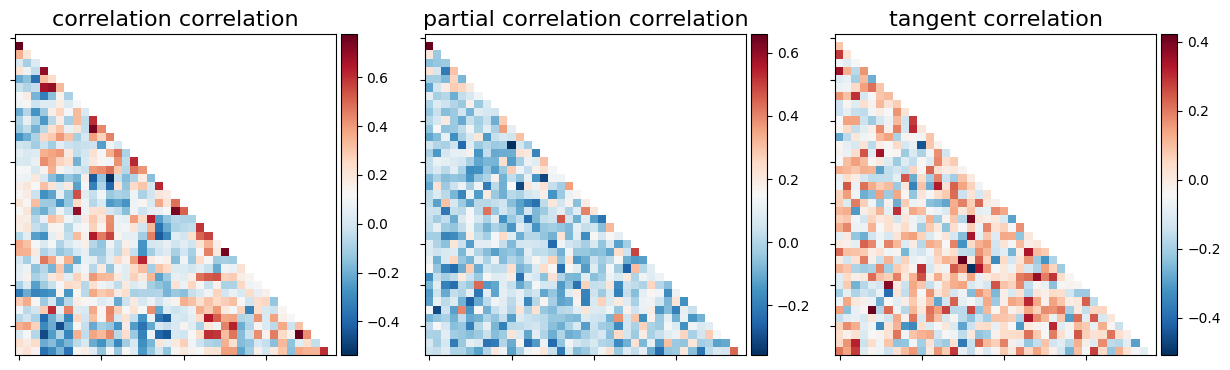

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import os

# Load correlation matrices from saved files
corr_save_dir = os.path.expanduser("~/correlation_matrices")
correlation_matrices = {}

for kind in ["correlation", "partial correlation", "tangent"]:
    file_path = os.path.join(corr_save_dir, f"{kind}_correlation_matrices.npz")
    data = np.load(file_path)
    correlation_matrices[kind] = data["matrices"]

# Select the first subject
subject_idx = 0

# Plot correlation matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, kind in enumerate(["correlation", "partial correlation", "tangent"]):
    matrix = correlation_matrices[kind][subject_idx]
    plotting.plot_matrix(matrix, tri="lower", axes=axes[i], title=f"{kind} correlation")

plt.show()


# 6. Check Correlation Values and Normalize

Correlation matrix value range: min=0.0009102461236479196, max=1.0


<Figure size 500x500 with 0 Axes>

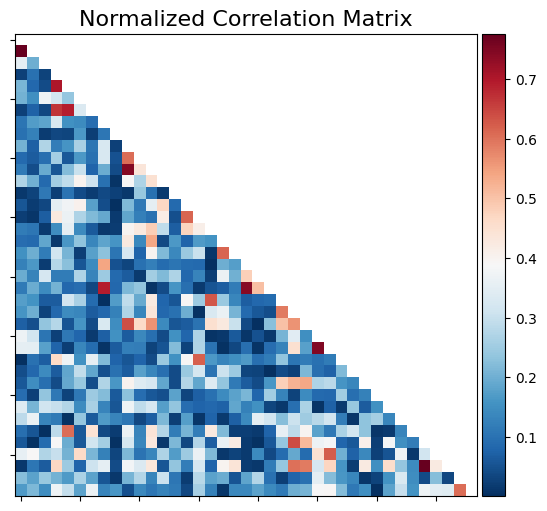

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

# Select one subject (e.g., first subject)
subject_idx = 0

# Load subject's correlation matrix (change type if needed: "correlation", "partial correlation", "tangent")
corr_matrix = correlation_matrices["correlation"][subject_idx]

# Normalize: Take absolute values & set diagonal to 1
corr_matrix = np.abs(corr_matrix)
np.fill_diagonal(corr_matrix, 1)

# Check value range
print(f"Correlation matrix value range: min={corr_matrix.min()}, max={corr_matrix.max()}")

# Visualize the normalized correlation matrix
plt.figure(figsize=(5,5))
plotting.plot_matrix(corr_matrix, tri="lower", title="Normalized Correlation Matrix")
plt.show()


Analysis of the Plot
Range Check:

The color scale shows values between 0 and ~0.75.
This means most correlations are low to moderate.
Threshold Selection:

To keep meaningful connections, we should choose a threshold where weak connections (blue) are removed, but we don’t lose too much structure.
Based on this plot, a reasonable starting point would be thresholds in the range of 0.2 to 0.5.

# 7. Apply a Threshold to Create an Adjacency Matrix

<Figure size 500x500 with 0 Axes>

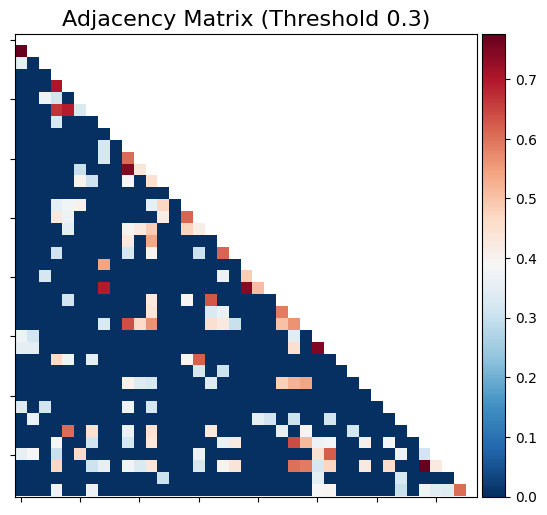

Adjacency matrix shape: (39, 39)
Number of edges: 153


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

def threshold_correlation_matrix(corr_matrix, threshold):
    """Applies thresholding to convert correlation matrix into an adjacency matrix."""
    adjacency_matrix = np.where(corr_matrix >= threshold, corr_matrix, 0)
    np.fill_diagonal(adjacency_matrix, 0)  # Remove self-connections
    return adjacency_matrix

# Apply threshold (set it to 0.3 for now)
threshold = 0.3
adjacency_matrix = threshold_correlation_matrix(corr_matrix, threshold)

# Visualize adjacency matrix
plt.figure(figsize=(5,5))
plotting.plot_matrix(adjacency_matrix, tri="lower", title=f"Adjacency Matrix (Threshold {threshold})")
plt.show()

# Print some stats
print(f"Adjacency matrix shape: {adjacency_matrix.shape}")
print(f"Number of edges: {np.count_nonzero(adjacency_matrix) // 2}")  # Since undirected graph


# 8. Automate Thresholding for All Subjects

In [10]:
import os
import numpy as np

# Define save directory for graphs
graph_save_dir = os.path.expanduser("~/graph_data")
os.makedirs(graph_save_dir, exist_ok=True)

# Define thresholds
thresholds = np.arange(0.1, 1.0, 0.1)  # [0.1, 0.2, ..., 0.9]

def threshold_correlation_matrix(corr_matrix, threshold):
    """Applies thresholding to convert correlation matrix into an adjacency matrix."""
    adjacency_matrix = np.where(corr_matrix >= threshold, corr_matrix, 0)
    np.fill_diagonal(adjacency_matrix, 0)  # Remove self-connections
    return adjacency_matrix

# Automate graph creation for all subjects and correlation types
for kind in correlation_matrices:  # Iterate over correlation types
    for threshold in thresholds:  # Iterate over thresholds
        save_path = os.path.join(graph_save_dir, f"{kind}_thresh_{threshold:.1f}.npz")
        
        adjacency_matrices = np.array([
            threshold_correlation_matrix(corr_matrix, threshold) 
            for corr_matrix in correlation_matrices[kind]
        ])

        # Save the adjacency matrices
        np.savez(save_path, matrices=adjacency_matrices)

print(f"All adjacency matrices saved in: {graph_save_dir}")


All adjacency matrices saved in: /Users/anushamourshed/graph_data


# ✅CHECKPOINT
- 155 subjects loaded & processed
- Time-series extracted successfully
- Correlation matrices computed & saved ((155, 39, 39))
- Adjacency matrices generated & saved for all thresholds & correlation types

# 9. Extract PCA Features

In [11]:
from sklearn.decomposition import PCA
import numpy as np
import os

# Load saved time-series data
time_series_dir = os.path.expanduser("~/time_series_data")

# Define number of PCA components
n_pca_components = 10

# Extract PCA features for all subjects
pca_features = []
for idx in range(155):
    file_path = os.path.join(time_series_dir, f"subject_{idx}.npz")
    data = np.load(file_path)
    time_series = np.array(data["time_series"])
    
    # Apply PCA
    pca = PCA(n_components=n_pca_components)
    pca_features.append(pca.fit_transform(time_series))

pca_features = np.array(pca_features)

# Save PCA features
pca_save_path = os.path.expanduser("~/graph_data/pca_features.npz")
np.savez(pca_save_path, features=pca_features)

print(f"PCA features saved in: {pca_save_path}")


PCA features saved in: /Users/anushamourshed/graph_data/pca_features.npz


# 10. Extract Node Strength

In [12]:
# Extract node strength for all subjects & correlation types
node_strengths = {kind: [] for kind in ["correlation", "partial correlation", "tangent"]}

for kind in correlation_matrices:
    for matrix in correlation_matrices[kind]:
        strength = np.sum(np.abs(matrix), axis=1)  # Sum of absolute values per node
        node_strengths[kind].append(strength)

# Convert to numpy arrays
for kind in node_strengths:
    node_strengths[kind] = np.array(node_strengths[kind])

# Save node strength features
node_strength_path = os.path.expanduser("~/graph_data/node_strengths.npz")
np.savez(node_strength_path, **node_strengths)

print(f"Node strength features saved in: {node_strength_path}")


Node strength features saved in: /Users/anushamourshed/graph_data/node_strengths.npz


# 11. Extract Labels from Time Series Files

In [13]:
import numpy as np
import os

time_series_dir = os.path.expanduser("~/time_series_data")
subject_labels = []

# Extract labels from each subject's saved time-series file
for idx in range(155):
    file_path = os.path.join(time_series_dir, f"subject_{idx}.npz")
    
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found! Skipping.")
        continue
    
    data = np.load(file_path)
    
    if "label" not in data:
        print(f"Warning: Label missing in {file_path}.")
        continue
    
    subject_labels.append(data["label"])  # Extract label

# Convert list to numpy array and save
subject_labels = np.array(subject_labels)
label_save_path = os.path.join(time_series_dir, "subject_labels.npy")
np.save(label_save_path, subject_labels)

print(f"Labels saved at: {label_save_path}")


Labels saved at: /Users/anushamourshed/time_series_data/subject_labels.npy


In [14]:
import os
print("Files in time_series_data:", os.listdir(os.path.expanduser("~/time_series_data")))


Files in time_series_data: ['subject_88.npz', 'subject_63.npz', 'subject_77.npz', 'subject_76.npz', 'subject_62.npz', 'subject_89.npz', 'subject_74.npz', 'subject_60.npz', 'subject_48.npz', 'subject_149.npz', 'subject_148.npz', 'subject_49.npz', 'subject_61.npz', 'subject_75.npz', 'subject_59.npz', 'subject_71.npz', 'subject_65.npz', 'subject_64.npz', 'subject_70.npz', 'subject_58.npz', 'subject_99.npz', 'subject_66.npz', 'subject_72.npz', 'subject_73.npz', 'subject_67.npz', 'subject_98.npz', 'subject_115.npz', 'subject_14.npz', 'subject_101.npz', 'subject_129.npz', 'subject_6.npz', 'subject_28.npz', 'subject_29.npz', 'subject_7.npz', 'subject_128.npz', 'subject_100.npz', 'subject_15.npz', 'subject_114.npz', 'subject_17.npz', 'subject_102.npz', 'subject_116.npz', 'subject_5.npz', 'subject_4.npz', 'subject_117.npz', 'subject_103.npz', 'subject_16.npz', 'subject_0.npz', 'subject_12.npz', 'subject_107.npz', 'subject_113.npz', 'subject_112.npz', 'subject_106.npz', 'subject_13.npz', 'subjec

In [15]:
import numpy as np

labels = np.load(os.path.expanduser("~/time_series_data/subject_labels.npy"))
print("Unique labels:", np.unique(labels))



Unique labels: ['adult' 'child']


### Convert Labels from string to binary

In [16]:
import numpy as np
import os

# Load original string labels
label_path = os.path.expanduser("~/time_series_data/subject_labels.npy")
labels = np.load(label_path)

# Convert string labels to integers
label_map = {"child": 0, "adult": 1}
numeric_labels = np.array([label_map[label] for label in labels])

# Save corrected labels
corrected_label_path = os.path.join(os.path.expanduser("~/time_series_data"), "subject_labels.npy")
np.save(corrected_label_path, numeric_labels)

print(f"Corrected labels saved at: {corrected_label_path}")
print("Unique numeric labels:", np.unique(numeric_labels))


Corrected labels saved at: /Users/anushamourshed/time_series_data/subject_labels.npy
Unique numeric labels: [0 1]


# 12. Train Test Split

In [49]:
from sklearn.model_selection import train_test_split

# Load PCA features
pca_features = np.load(os.path.expanduser("~/graph_data/pca_features.npz"))["features"]

# Load numeric labels
numeric_labels = np.load(os.path.expanduser("~/time_series_data/subject_labels.npy"))

# Split dataset (80% train, 20% test)
train_pca, test_pca, train_labels, test_labels = train_test_split(
    pca_features, numeric_labels, test_size=0.2, stratify=numeric_labels, random_state=42
)

print(f"✅ Train size: {len(train_labels)}, Test size: {len(test_labels)}")


✅ Train size: 124, Test size: 31


# 13. Load and Split Adjacency Matrices

In [52]:
from itertools import product

# Define available thresholds
thresholds = np.arange(0.1, 1.0, 0.1)  # [0.1, 0.2, ..., 0.9]
correlation_matrices = ["correlation", "tangent", "partial correlation"]


# Dictionary to store adjacency matrices for each (correlation matrix, threshold) pair
train_adj_comb_dict = {}
test_adj_comb_dict = {}

# Iterate over all possible (correlation matrix, threshold) combinations
for corr_matrix, threshold in product(correlation_matrices, thresholds):
    key = f"corr_{corr_matrix}_thresh_{threshold:.1f}"  # Unique key for each combination

    # Check if adjacency matrix exists for this combination
    threshold_file = os.path.join(graph_save_dir, f"{corr_matrix}_thresh_{threshold:.1f}.npz")

    if not os.path.exists(threshold_file):
        print(f"⚠ Skipping {key} (file not found).")
        continue

    # Load adjacency matrices
    adjacency_matrices = np.load(threshold_file)["matrices"]

    # Perform train-test split
    train_adj, test_adj = train_test_split(
        adjacency_matrices, test_size=0.2, stratify=numeric_labels, random_state=42
    )

    # Store in dictionaries
    train_adj_comb_dict[key] = train_adj
    test_adj_comb_dict[key] = test_adj

    print(f"✅ Loaded Adjacency Matrices for {key} - Train: {train_adj.shape}, Test: {test_adj.shape}")


✅ Loaded Adjacency Matrices for corr_correlation_thresh_0.1 - Train: (124, 39, 39), Test: (31, 39, 39)
✅ Loaded Adjacency Matrices for corr_correlation_thresh_0.2 - Train: (124, 39, 39), Test: (31, 39, 39)
✅ Loaded Adjacency Matrices for corr_correlation_thresh_0.3 - Train: (124, 39, 39), Test: (31, 39, 39)
✅ Loaded Adjacency Matrices for corr_correlation_thresh_0.4 - Train: (124, 39, 39), Test: (31, 39, 39)
✅ Loaded Adjacency Matrices for corr_correlation_thresh_0.5 - Train: (124, 39, 39), Test: (31, 39, 39)
✅ Loaded Adjacency Matrices for corr_correlation_thresh_0.6 - Train: (124, 39, 39), Test: (31, 39, 39)
✅ Loaded Adjacency Matrices for corr_correlation_thresh_0.7 - Train: (124, 39, 39), Test: (31, 39, 39)
✅ Loaded Adjacency Matrices for corr_correlation_thresh_0.8 - Train: (124, 39, 39), Test: (31, 39, 39)
✅ Loaded Adjacency Matrices for corr_correlation_thresh_0.9 - Train: (124, 39, 39), Test: (31, 39, 39)
✅ Loaded Adjacency Matrices for corr_tangent_thresh_0.1 - Train: (124, 39

# 14. Convert Adjacency Matrices to Graph Data

In [53]:
import torch
from torch_geometric.data import Data, DataLoader

def create_graph_data(adjacency_matrices, node_features, labels):
    graph_data = []
    for i in range(len(labels)):
        edge_index = torch.tensor(np.array(np.nonzero(adjacency_matrices[i])), dtype=torch.long)
        x = torch.tensor(node_features[i], dtype=torch.float)  # PCA features as node embeddings
        y = torch.tensor([labels[i]], dtype=torch.long)  # 🔥 Wrap label in a list for correct shape

        graph_data.append(Data(x=x, edge_index=edge_index, y=y))  # ✅ Graph-level labels

    return graph_data

# Store train/test graph datasets for all (correlation matrix, threshold) combinations
train_graph_comb_dict = {}
test_graph_comb_dict = {}

for key in train_adj_comb_dict:
    train_graph_comb_dict[key] = create_graph_data(train_adj_comb_dict[key], train_pca, train_labels)
    test_graph_comb_dict[key] = create_graph_data(test_adj_comb_dict[key], test_pca, test_labels)

    print(f"✅ Created Graph Data for {key} - Train: {len(train_graph_comb_dict[key])}, Test: {len(test_graph_comb_dict[key])}")


✅ Created Graph Data for corr_correlation_thresh_0.1 - Train: 124, Test: 31
✅ Created Graph Data for corr_correlation_thresh_0.2 - Train: 124, Test: 31
✅ Created Graph Data for corr_correlation_thresh_0.3 - Train: 124, Test: 31
✅ Created Graph Data for corr_correlation_thresh_0.4 - Train: 124, Test: 31
✅ Created Graph Data for corr_correlation_thresh_0.5 - Train: 124, Test: 31
✅ Created Graph Data for corr_correlation_thresh_0.6 - Train: 124, Test: 31
✅ Created Graph Data for corr_correlation_thresh_0.7 - Train: 124, Test: 31
✅ Created Graph Data for corr_correlation_thresh_0.8 - Train: 124, Test: 31
✅ Created Graph Data for corr_correlation_thresh_0.9 - Train: 124, Test: 31
✅ Created Graph Data for corr_tangent_thresh_0.1 - Train: 124, Test: 31
✅ Created Graph Data for corr_tangent_thresh_0.2 - Train: 124, Test: 31
✅ Created Graph Data for corr_tangent_thresh_0.3 - Train: 124, Test: 31
✅ Created Graph Data for corr_tangent_thresh_0.4 - Train: 124, Test: 31
✅ Created Graph Data for cor

# 15. Create DataLoaders for Each Combination

In [54]:
from torch_geometric.loader import DataLoader

# Store DataLoaders for each combination
train_loader_comb_dict = {}
test_loader_comb_dict = {}

for key in train_graph_comb_dict:
    train_loader_comb_dict[key] = DataLoader(train_graph_comb_dict[key], batch_size=32, shuffle=True)
    test_loader_comb_dict[key] = DataLoader(test_graph_comb_dict[key], batch_size=32, shuffle=False)

print("✅ DataLoaders Created for All Combinations!")


✅ DataLoaders Created for All Combinations!


# 16. Define the GCN Model

In [55]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)  # 🔥 Fully connected layer for graph classification

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # 🔥 Aggregates node embeddings into a single graph representation
        return self.fc(x)  # ✅ Outputs one prediction per graph

print("✅ GCN Model Defined!")


✅ GCN Model Defined!


# 17. Train GCN for Each Combination

In [57]:
import torch.optim as optim

# Store trained models
trained_models_comb = {}

# Define the training function
def train_model(train_loader, model, optimizer, criterion, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

    return model

# Train GCN for each (correlation matrix, threshold) combination
for key in train_loader_comb_dict:
    print(f"\n🚀 Training GCN for {key}...")

    # Initialize model
    input_dim = train_loader_comb_dict[key].dataset[0].x.shape[1]  # PCA feature size
    hidden_dim = 32
    output_dim = 2  # Binary classification (Child vs. Adult)

    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Train the model
    trained_model = train_model(train_loader_comb_dict[key], model, optimizer, criterion, epochs=50)

    # Store trained model
    trained_models_comb[key] = trained_model

    print(f"✅ Training Completed for {key}!")



🚀 Training GCN for corr_correlation_thresh_0.1...
Epoch 10/50 - Loss: 0.5170
Epoch 20/50 - Loss: 0.5129
Epoch 30/50 - Loss: 0.4900
Epoch 40/50 - Loss: 0.4032
Epoch 50/50 - Loss: 0.3515
✅ Training Completed for corr_correlation_thresh_0.1!

🚀 Training GCN for corr_correlation_thresh_0.2...
Epoch 10/50 - Loss: 0.5162
Epoch 20/50 - Loss: 0.5136
Epoch 30/50 - Loss: 0.5040
Epoch 40/50 - Loss: 0.4852
Epoch 50/50 - Loss: 0.4415
✅ Training Completed for corr_correlation_thresh_0.2!

🚀 Training GCN for corr_correlation_thresh_0.3...
Epoch 10/50 - Loss: 0.5115
Epoch 20/50 - Loss: 0.5097
Epoch 30/50 - Loss: 0.5018
Epoch 40/50 - Loss: 0.4653
Epoch 50/50 - Loss: 0.3842
✅ Training Completed for corr_correlation_thresh_0.3!

🚀 Training GCN for corr_correlation_thresh_0.4...
Epoch 10/50 - Loss: 0.5162
Epoch 20/50 - Loss: 0.5156
Epoch 30/50 - Loss: 0.5023
Epoch 40/50 - Loss: 0.4585
Epoch 50/50 - Loss: 0.3931
✅ Training Completed for corr_correlation_thresh_0.4!

🚀 Training GCN for corr_correlation_thr

# 18. Evaluate All Models

In [58]:
def evaluate_model(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            pred = out.argmax(dim=1)  # Get predicted class (0 or 1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)

    accuracy = correct / total
    return accuracy

# Store accuracy for each combination
accuracy_comb_dict = {}

for key in test_loader_comb_dict:
    print(f"\n🧪 Evaluating Model for {key}...")

    accuracy = evaluate_model(test_loader_comb_dict[key], trained_models_comb[key])
    accuracy_comb_dict[key] = accuracy

    print(f"✅ Accuracy for {key}: {accuracy:.4f}")



🧪 Evaluating Model for corr_correlation_thresh_0.1...
✅ Accuracy for corr_correlation_thresh_0.1: 0.7419

🧪 Evaluating Model for corr_correlation_thresh_0.2...
✅ Accuracy for corr_correlation_thresh_0.2: 0.7742

🧪 Evaluating Model for corr_correlation_thresh_0.3...
✅ Accuracy for corr_correlation_thresh_0.3: 0.7742

🧪 Evaluating Model for corr_correlation_thresh_0.4...
✅ Accuracy for corr_correlation_thresh_0.4: 0.7742

🧪 Evaluating Model for corr_correlation_thresh_0.5...
✅ Accuracy for corr_correlation_thresh_0.5: 0.6774

🧪 Evaluating Model for corr_correlation_thresh_0.6...
✅ Accuracy for corr_correlation_thresh_0.6: 0.7742

🧪 Evaluating Model for corr_correlation_thresh_0.7...
✅ Accuracy for corr_correlation_thresh_0.7: 0.7742

🧪 Evaluating Model for corr_correlation_thresh_0.8...
✅ Accuracy for corr_correlation_thresh_0.8: 0.7742

🧪 Evaluating Model for corr_correlation_thresh_0.9...
✅ Accuracy for corr_correlation_thresh_0.9: 0.7742

🧪 Evaluating Model for corr_tangent_thresh_0.

# 19. Visualize Accuracy Results

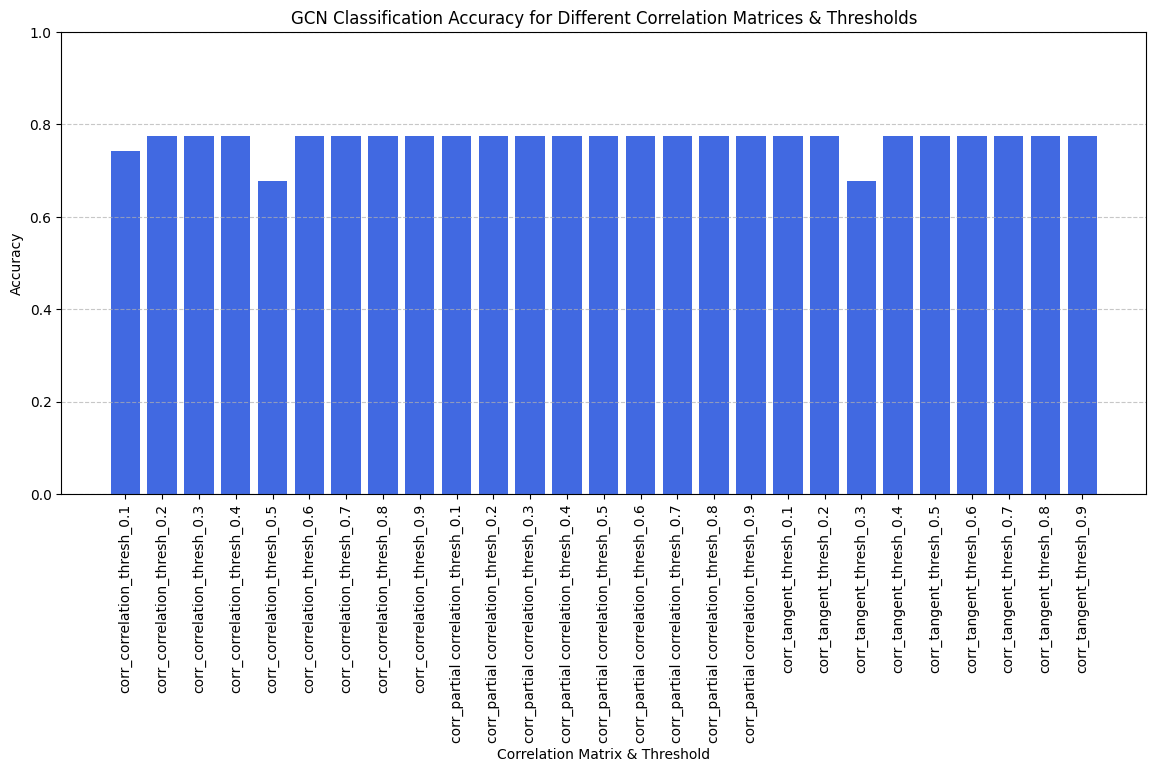

In [59]:
import matplotlib.pyplot as plt

# Sort keys for better visualization
sorted_keys = sorted(accuracy_comb_dict.keys())

# Extract values for plotting
accuracies = [accuracy_comb_dict[key] for key in sorted_keys]

# Plot accuracy results
plt.figure(figsize=(14, 6))
plt.bar(sorted_keys, accuracies, color='royalblue')
plt.xticks(rotation=90, fontsize=10)
plt.ylabel("Accuracy")
plt.xlabel("Correlation Matrix & Threshold")
plt.title("GCN Classification Accuracy for Different Correlation Matrices & Thresholds")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
